/Users/jason/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Logistic Regression Report
Threshold:          0.5
Accuracy:           0.6082
Precision:          0.6018
Recall:             0.4073
F1 Score:           0.4858
AUC (ROC):          0.6354

Confusion Matrix:
[[3083  892]
 [1962 1348]]

Creating visualization figure for logistic regression...
✓ Visualization saved: logistic_results.png


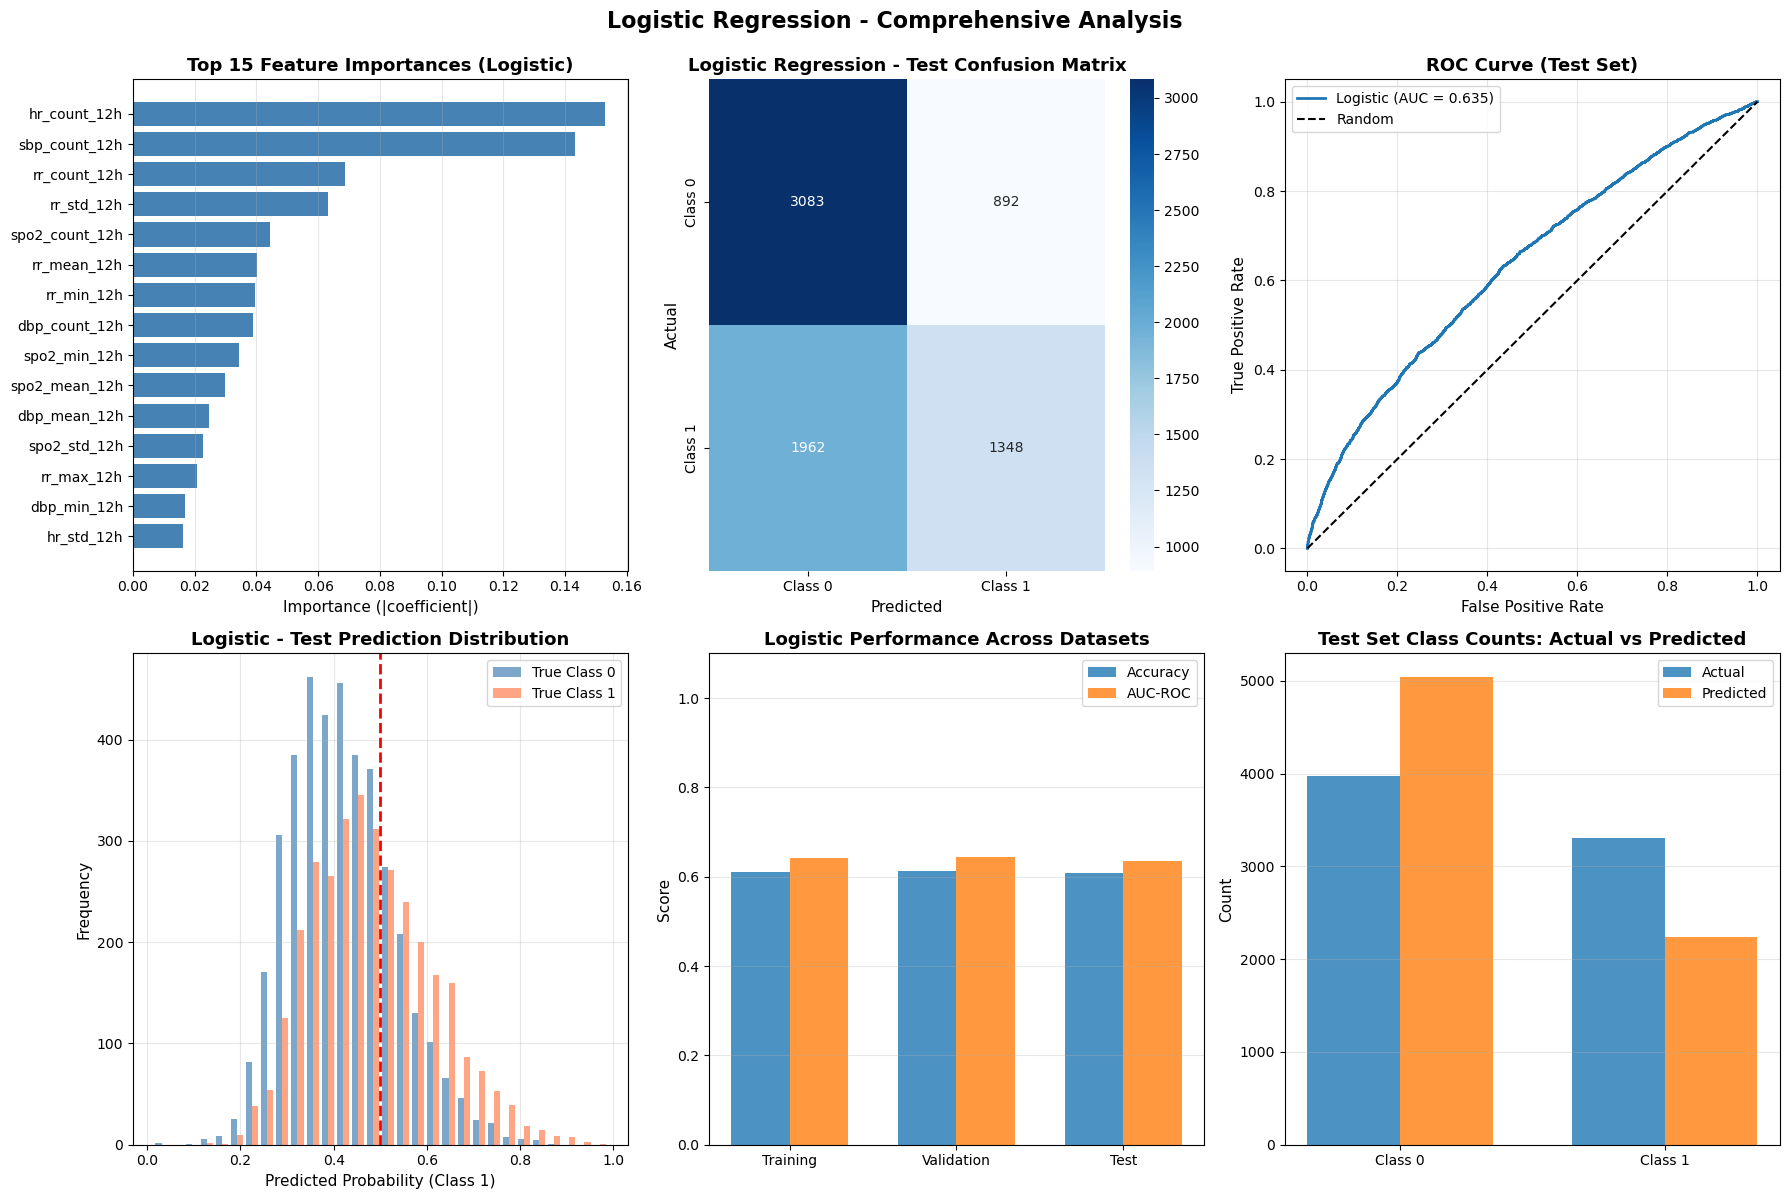

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data_with_split.csv")  


train_df = df[df["split"] == 0]
val_df   = df[df["split"] == 1]
test_df  = df[df["split"] == 2]

X_train = train_df.drop(columns=["label", "split"])
y_train = train_df["label"]

X_val   = val_df.drop(columns=["label", "split"])
y_val   = val_df["label"]

X_test  = test_df.drop(columns=["label", "split"])
y_test  = test_df["label"]

feature_names = X_train.columns.tolist()


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predicted probabilities for class 1 on each split
y_train_prob_log = log_reg.predict_proba(X_train)[:, 1]
y_val_prob_log   = log_reg.predict_proba(X_val)[:, 1]
y_prob_log       = log_reg.predict_proba(X_test)[:, 1]

# Threshold at 0.5 to get class predictions
threshold = 0.5
y_train_log_class = (y_train_prob_log >= threshold).astype(int)
y_val_log_class   = (y_val_prob_log   >= threshold).astype(int)
y_pred_log_class  = (y_prob_log       >= threshold).astype(int)

# Metrics (test set)
log_accuracy  = accuracy_score(y_test, y_pred_log_class)
log_precision = precision_score(y_test, y_pred_log_class, zero_division=0)
log_recall    = recall_score(y_test, y_pred_log_class, zero_division=0)
log_f1        = f1_score(y_test, y_pred_log_class, zero_division=0)
log_auc       = roc_auc_score(y_test, y_prob_log)
log_cm        = confusion_matrix(y_test, y_pred_log_class)

print("===============================================")
print("  Logistic Regression Report")
print("===============================================")
print(f"Threshold:          {threshold}")
print(f"Accuracy:           {log_accuracy:.4f}")
print(f"Precision:          {log_precision:.4f}")
print(f"Recall:             {log_recall:.4f}")
print(f"F1 Score:           {log_f1:.4f}")
print(f"AUC (ROC):          {log_auc:.4f}")
print("\nConfusion Matrix:")
print(log_cm)
print("===============================================\n")

# =======================================================
# CREATE FIGURE (logistic only, RF-style 2x3 layout)
# =======================================================
print("Creating visualization figure for logistic regression...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# -------------------------------------------------------
# 1. Top-left: "Feature importances" from |coefficients|
# -------------------------------------------------------
log_coef = log_reg.coef_.ravel()
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": log_coef,
    "importance": np.abs(log_coef)   # treat |coef| as importance
}).sort_values("importance", ascending=False)

top_k = 15
top_imp = coef_df.head(top_k)

axes[0, 0].barh(range(len(top_imp)), top_imp["importance"], color="steelblue")
axes[0, 0].set_yticks(range(len(top_imp)))
axes[0, 0].set_yticklabels(top_imp["feature"])
axes[0, 0].set_xlabel("Importance (|coefficient|)", fontsize=11)
axes[0, 0].set_title("Top 15 Feature Importances (Logistic)",
                     fontsize=13, fontweight="bold")
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis="x", alpha=0.3)

# -------------------------------------------------------
# 2. Top-middle: Confusion Matrix (Logistic, test set)
# -------------------------------------------------------
sns.heatmap(
    log_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0, 1],
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
axes[0, 1].set_xlabel("Predicted", fontsize=11)
axes[0, 1].set_ylabel("Actual", fontsize=11)
axes[0, 1].set_title("Logistic Regression - Test Confusion Matrix",
                     fontsize=13, fontweight="bold")

# -------------------------------------------------------
# 3. Top-right: ROC Curve (Logistic, test set)
# -------------------------------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

axes[0, 2].plot(fpr_log, tpr_log, linewidth=2,
                label=f"Logistic (AUC = {log_auc:.3f})")
axes[0, 2].plot([0, 1], [0, 1], "k--", label="Random")
axes[0, 2].set_xlabel("False Positive Rate", fontsize=11)
axes[0, 2].set_ylabel("True Positive Rate", fontsize=11)
axes[0, 2].set_title("ROC Curve (Test Set)",
                     fontsize=13, fontweight="bold")
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(alpha=0.3)

# -------------------------------------------------------
# 4. Bottom-left: Prediction probability distribution (Logistic, test)
# -------------------------------------------------------
axes[1, 0].hist(
    [y_prob_log[y_test == 0], y_prob_log[y_test == 1]],
    bins=30,
    label=["True Class 0", "True Class 1"],
    alpha=0.7,
    color=["steelblue", "coral"],
)
axes[1, 0].set_xlabel("Predicted Probability (Class 1)", fontsize=11)
axes[1, 0].set_ylabel("Frequency", fontsize=11)
axes[1, 0].set_title("Logistic - Test Prediction Distribution",
                     fontsize=13, fontweight="bold")
axes[1, 0].legend(fontsize=10)
axes[1, 0].axvline(x=threshold, color="red", linestyle="--", linewidth=2,
                   label=f"Threshold = {threshold}")
axes[1, 0].grid(alpha=0.3)

# -------------------------------------------------------
# 5. Bottom-middle: Performance across datasets (Logistic)
# -------------------------------------------------------
datasets = ["Training", "Validation", "Test"]
log_accuracies = [
    accuracy_score(y_train, y_train_log_class),
    accuracy_score(y_val,   y_val_log_class),
    log_accuracy,
]
log_aucs = [
    roc_auc_score(y_train, y_train_prob_log),
    roc_auc_score(y_val,   y_val_prob_log),
    log_auc,
]

x = np.arange(len(datasets))
width = 0.35

color_acc = "tab:blue"
color_auc = "tab:orange"

axes[1, 1].bar(x - width/2, log_accuracies, width,
               label="Accuracy", alpha=0.8, color=color_acc)
axes[1, 1].bar(x + width/2, log_aucs,       width,
               label="AUC-ROC", alpha=0.8, color=color_auc)
axes[1, 1].set_ylabel("Score", fontsize=11)
axes[1, 1].set_title("Logistic Performance Across Datasets",
                     fontsize=13, fontweight="bold")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(datasets)
axes[1, 1].legend(fontsize=10)
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].grid(axis="y", alpha=0.3)

# -------------------------------------------------------
# 6. Bottom-right: Actual vs Predicted class counts (Test set)
#      — reuse the same blue (Accuracy) + orange (AUC) colors
# -------------------------------------------------------
test_counts_actual = pd.Series(y_test).value_counts().reindex([0, 1], fill_value=0)
test_counts_pred   = pd.Series(y_pred_log_class).value_counts().reindex([0, 1], fill_value=0)

classes = ["Class 0", "Class 1"]
x_cls = np.arange(len(classes))
width2 = 0.35

axes[1, 2].bar(x_cls - width2/2, test_counts_actual.values,
               width2, label="Actual", alpha=0.8, color=color_acc)
axes[1, 2].bar(x_cls + width2/2, test_counts_pred.values,
               width2, label="Predicted", alpha=0.8, color=color_auc)

axes[1, 2].set_xticks(x_cls)
axes[1, 2].set_xticklabels(classes)
axes[1, 2].set_ylabel("Count", fontsize=11)
axes[1, 2].set_title("Test Set Class Counts: Actual vs Predicted",
                     fontsize=13, fontweight="bold")
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(axis="y", alpha=0.3)

plt.suptitle("Logistic Regression - Comprehensive Analysis",
             fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout()

viz_path = "logistic_results.png"
plt.savefig(viz_path, dpi=300, bbox_inches="tight", facecolor="white")
print(f"✓ Visualization saved: {viz_path}")


In [16]:
print("Train/Val/Test accuracy:", log_accuracies)
print("Train/Val/Test AUC:      ", log_aucs)


Train/Val/Test accuracy: [0.6108543449411981, 0.613315030885381, 0.6082361015785861]
Train/Val/Test AUC:       [0.6408973913515275, 0.6432749313855648, 0.6354070949476525]
